In [1075]:
import matplotlib.pyplot as plt
%matplotlib inline

import random as r
from math import sqrt, cos, sin

b=[r.uniform(1,7) for i in range(5)]
unclassified_points=[]

for rad in b:
    a=[r.uniform(0,6.2831853072) for i in range(100)]
    unclassified_points=unclassified_points+[[rad*cos(3*c),rad*sin(2*c)] for c in a]

"""
    The below line generates 3d data, which can also be handled by the implementations
    (though plotting doesn't work)
"""        
#unclassified_points=[[r.uniform(-5,5),r.triangular(-5,5, 0), r.uniform(-5,5)] for i in range(200)]

"\n    The below line generates 3d data, which can also be handled by the implementations\n    (though plotting doesn't work)\n"

# k-Means Implementation

In [1076]:
class kMeans:
    def __init__(self, points, num_centroids):
        self.points=points
        self.num_centroids=num_centroids
        self.colors=[[[r.random() for i in range(3)]] for j in range(num_centroids)]
        #Nodes selected randomly from points
        self.centroids=[self.points[i] for i in r.sample(range(len(self.points)), num_centroids)]
        self.groups=[]
        
    def metric(self,a,b):
        """
            Standard L2 metric function
        """
        return(sqrt(sum([(i-j)**2 for i,j in zip(a,b)])))
    
    def find_centroid(self,point):
        """
            Finds nearest centroid
        """
        dist=[self.metric(point, centroid) for centroid in self.centroids]
        return(dist.index(min(dist)))
    
    def centroid_update(self, group):
        """
            Returns centroid of group
        """
        N=len(group)
        group_sum=[sum(coordinate) for coordinate in zip(*group)]
        return([coordinate/N for coordinate in group_sum])
    
    def fit_group_update(self):
        """
            Add all points to groups and then updates centroids
        """
        groups=[[] for i in range(self.num_centroids)]
        
        for point in self.points:
            groups[self.find_centroid(point)].append(point)
            
        new_centroids=[self.centroid_update(group) for group in groups]
        
        self.centroids=new_centroids
        self.groups=groups
        
    def fit_groups(self, times=10):
        """
            Just runs fit_group_update some number of times and then adds points
            to nearest centroid one final time
        """
        for i in range(times):
            self.fit_group_update()
            
        groups=[[] for i in range(self.num_centroids)]
        
        for point in self.points:
            groups[self.find_centroid(point)].append(point)
            
        self.groups=groups
            
    def color_update(self):
        """
            Changes colors
        """
        self.colors=[[[r.random() for i in range(3)]] for j in range(self.num_centroids)]
        
    def plot_points(self):
        """
            Plots all points
        """
        fig, ax = plt.subplots()
        plt.scatter(*zip(*self.points))
        ax.set_aspect(1) 
            
    def plot_groups(self):
        """
            Plots all groups and centroids
        """
        if self.groups:
            fig, ax = plt.subplots()
            ax.set_aspect(1)

            for group, centroid, num in zip(self.groups, self.centroids, range(self.num_centroids)):
                plt.scatter(*zip(*group), c=self.colors[num])
                plt.scatter(*centroid, c=self.colors[num], s=120, edgecolors='black')
        else:
            self.fit_groups()
            self.plot_groups()

In [1077]:
kMeans_cluster=kMeans(unclassified_points,5)
kMeans_cluster.fit_groups(times=20)

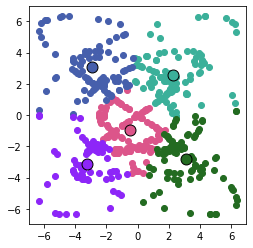

In [1078]:
kMeans_cluster.plot_groups()

# DBSCAN Implementation

In [1079]:
class DBSCAN:
    def __init__(self, points, min_neighbors, max_dist):
        self.points=points
        self.min_neighbors=min_neighbors
        self.max_dist=max_dist
        self.groups=[]
        self.noise=[]
        self.colors=[]
        
    def metric(self,a,b):
        """
            Standard L2 metric function
        """
        return(sqrt(sum([(i-j)**2 for i,j in zip(a,b)])))
    
    def find_neighbors(self, point):
        """
            Returns a list of all neighboring points if there are at least min_neighbor many of them
        """
        #Find all close by neighbors
        neighbors_dist=[self.metric(point, neighbor)<=self.max_dist for neighbor in self.points]
        
        #Return close neighbors if there is enough of them
        if sum(neighbors_dist)>=self.min_neighbors:
            return([point for point, dist in zip(self.points, neighbors_dist) if dist])
        else:
            return()
        
    def find_group(self, center):
        """
            Finds group centered at center
        """
        group=[]
        #Check if a new group is actually going to be made
        if not self.find_neighbors(center):
            return()

        #List of points which have been added by a neighbor
        temp_group=[center]

        while temp_group:
            #Pop and add point in temp_group to actual group
            current_center=temp_group.pop(0)
            group.append(current_center)

            #Find neighbors of current point of interest
            neighbors=self.find_neighbors(current_center)
            
            #Add new things to temp_group to continue the chain
            for neighbor in neighbors:
                if neighbor not in group+temp_group:
                    temp_group.append(neighbor)
                    
        return(group)
    
    def fit_groups(self):
        """
            Fits groups to data and identifies noise
        """
        groups=[]
        unclassified_points=self.points.copy()
        noise=[]
        
        while unclassified_points:
            #Get current first unclassified point
            current_center=unclassified_points.pop(0)
            
            #Find group around point
            current_group=self.find_group(current_center)
            
            #If group is non-empty, add to groups and remove points from unclassified points
            if current_group: 
                for point in current_group:
                    if point in unclassified_points:
                        unclassified_points.remove(point)
    
                groups.append(current_group)
            
            #Else add to noise
            else:
                noise.append(current_center)
                
        if groups:        
            self.groups, self.noise=[groups, noise]
        else:
            raise NameError('No groups were found with current hyperparameters\n Try changing them')
        
        
    def color_update(self):
        """
            Updates colors
        """
        self.colors=[[[r.random() for i in range(3)]] for j in range(len(self.groups))]
    
    def plot_points(self, point=False):
        """
            Plots all points
        """
        fig, ax = plt.subplots()
        plt.scatter(*zip(*self.points))
        ax.set_aspect(1)
        if point:
            ax.add_artist(plt.Circle(point, self.max_dist, fill=False)) 
        
    def plot_group(self, center, circles=False):
        """
            Plots group centered at center, optionally with circles around points
        """
        group=self.find_group(center)
        noise=[point for point in self.points if point not in group]
        
        fig, ax = plt.subplots()
        plt.scatter(*zip(*noise), color='grey')
        plt.scatter(*zip(*group), color='blue')
        ax.set_aspect(1)
        
        if circles:
            for i in group:
                ax.add_artist(plt.Circle(i, self.max_dist, fill=False, color='blue'))       
    
    def plot_groups(self, circles=False):
        """
            Plots all groups, optionally with circles around points
        """
        #Checks if self.fit_groups() has been run or not
        if self.groups:
            if self.colors:
                fig, ax = plt.subplots()
                ax.set_aspect(1)

                if self.noise:
                    plt.scatter(*zip(*self.noise), color='grey', label="Noise")
                    plt.legend()

                for i in range(len(self.groups)):
                    plt.scatter(*zip(*self.groups[i]), c=self.colors[i])
                    if circles:
                        for point in self.groups[i]:
                            ax.add_artist(plt.Circle(point, self.max_dist, 
                                            fill=False, color=self.colors[i][0]))
            else:
                self.color_update()
                self.plot_groups(circles=circles)
        else:
            #Runs self.fit_groups() in case needed
            self.fit_groups()
            self.plot_groups(circles=circles)

In [1080]:
DBSCAN_cluster=DBSCAN(unclassified_points,4,0.5)

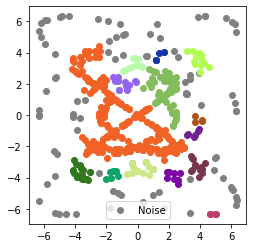

In [1081]:
DBSCAN_cluster.plot_groups()

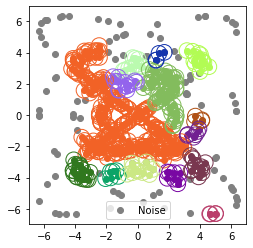

In [1082]:
DBSCAN_cluster.plot_groups(circles=True)